built to work with sequential data and data where we need to extend a sequence (like predicting values)

while CNNs can efficiently process spatial information, RNNs are designed to handle sequential information. 

RNNs introduce state variables to store past information and together with current inputs determine the current outputs. 

many examples of RNNs are based on text data. 

## Sequence Models

anchoring = people's opinion chaning because of someone else's opinion. 

hedonic adaptation = humans quickly adapt to accept an improved or worsened situation as new normal. 

phenomenon like these change sequential data like movie ratings. 

other examples of sequential data 

- stock prices

- music, text, speech, videos

- human interaction 

#### Statistical Tools

##### Autoregressive Models

most of it is predicting 
$$P(x_t \mid x_{t-1}, \ldots, x_1)$$

problem with this is, t is not the same for all problems. 

there are two strategies to solve this problem. 

1. autoregressive models:

we only take t' samples from the overall sample and this t' < t. as a result of this, the number of arguments is always the same. this allows us to train a deep network on it. as they perform regression on top of themselves, they are called auto regressive models. 

2. latent autoregressive models:

we keep some summary ht of the past observations and keep updating it. 

as a result prediction problem becomes

$$\hat{x}_t = P(x_t \mid h_{t})$$

and the updating becomes

$$h_t = g(h_{t-1}, x_{t-1})$$

!["latent autoregressive models"](./images/8/8.1.svg)


one assumption they make is the dynamics of the sequence dont change between the past data and the sample that's going to be predicted. statisticians call dynamics that do not change, stationary. 

##### Markov Models

in the autoregressive models, when the sample is taken only till t' instead of t-1 but is still accurate, we say the sequence satisfies a markov condition. 

if t' = 1, we have a first order markov model and P(x) is given by

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1)$$

they only take into account a very short history of past observations.

mostly used by control and reinforcement learning algorithms.

In [1]:
import matplotlib.pyplot as plt

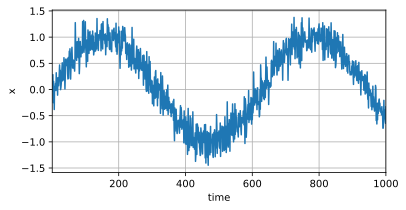

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
torch.normal(0, 0.2, (T,))

tensor([ 5.8803e-02,  3.9947e-01, -8.0615e-02,  3.2948e-01,  5.2019e-02,
        -6.4579e-02,  5.8461e-02, -2.0011e-01, -3.4888e-01, -2.9974e-02,
         1.8540e-01, -2.6183e-01,  2.6293e-01, -3.8928e-03,  2.5514e-01,
        -2.4616e-01, -6.4442e-02,  2.3249e-01,  2.7574e-02, -1.3600e-01,
         3.2924e-01, -1.5657e-03,  3.4273e-01,  2.3561e-01, -3.4294e-02,
         3.2992e-01, -6.0171e-02,  1.8799e-01, -9.0648e-02, -3.2330e-01,
        -2.3248e-01, -1.9346e-03, -2.6650e-01,  1.9915e-02, -1.3989e-01,
        -8.2092e-04,  3.6513e-02, -1.6651e-01, -1.1438e-01, -3.1967e-01,
        -1.5102e-01, -2.5295e-01, -1.6670e-01, -5.3670e-02,  1.1273e-01,
        -3.2608e-01, -1.2249e-01, -5.6283e-02,  2.3344e-01, -9.4802e-02,
        -1.7921e-01, -1.4559e-02, -1.9864e-02,  1.7458e-01, -1.6045e-01,
        -9.3930e-02,  1.0651e-01, -9.0624e-02,  1.5432e-01, -1.0806e-01,
         1.5707e-01,  1.3098e-01,  1.3983e-01, -2.1137e-01, -3.8984e-02,
         1.4833e-01, -1.6456e-01,  2.5319e-01,  7.3

now we turn sequences into features and labels that can be trained on. 

based on embedding dimensions t', we map data into pairs yt = xt and xt = [x t-t', ...., xt]

if we are picking t' and there are less than t' elements, pad them with zeros. if there are too many, discard the remaining. 

ValueError: Unrecognized character t in format string

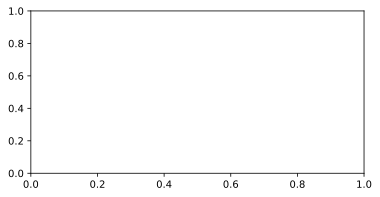

In [4]:
plt.plot(time, [x], 'time', 'x')

In [ ]:
t_d = 4
features = torch.zeros((T - t_d, t_d))
for i in range(t_d):
    features[:, i] = x[i:T - t_d + i]
labels = x[t_d:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first n_train are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train = True)

model architecture is


two fully connected layers, relu activation and squared loss

In [ ]:
# Initializing weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                       nn.ReLU(),
                       nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction = 'none')

In [ ]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

one step ahead prediction: predict what happens in the next time step

In [ ]:
onestep_preds = net(features)
d2l.plot([time, time[t_d:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

when we want tp predict past t, k values, it's called k-step-ahead prediction. 

in this, we use our own predictions to make multistep ahead prediction. 

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + t_d] = x[: n_train + t_d]
for i in range(n_train + t_d, T):
    multistep_preds[i] = net(
        multistep_preds[i - t_d:i].reshape((1, -1)))

d2l.plot([time, time[t_d:], time[n_train + t_d:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + t_d:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

as seen above, dotted line fails to predict properly. the error diverged after some time because of no data to correct itself. 

this is the reason why weather predictions are accurate for the next few hours but fail to predict beyond that. 

performing k step ahead for k = 1, 4, 16, 64

In [ ]:
max_steps = 64

features = torch.zeros((T - t_d - max_steps + 1, t_d + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(t_d):
    features[:, i] = x[i: i + T - t_d - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(t_d, t_d + max_steps):
    features[:, i] = net(features[:, i - t_d:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[t_d + i - 1: T - max_steps + i] for i in steps],
         [features[:, (t_d + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

till 4, it looks decent. beyond that predictions are bad. 

## Language Models and Dataset

after preprocessing the text data into tokens, the tokens can be viewed as a sequence of discrete observations. 

assume tokens of a sequence of length T are x1, x2, x3,...,xt.

task is, given a text sequence, the goal of language model is to estimate the joint probability of the sequnce 

$$P(x_1, x_2, \ldots, x_T).$$

